<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Visual Behavior Neuropixels Exercise 2: Active vs. Passive </h1> 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Visual stimuli refresher

As a reminder, every recording session consisted of three major visual stimulus epochs in the following order (diagrammed below):
- An active behavior session during which the mouse performed the change detection task
- Receptive field mapping and full-field flash stimuli
- 'Passive' replay of stimulus shown during active behavior, but without the lickspout so the mouse can no longer respond.
    
</div>

<div>
<img src="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public_thumbnails/filer_public/65/58/6558f0eb-c3c5-45e6-b645-b2e432200804/active_passive_diagram.png__710x291_q90_subsampling-2.png", width="900"/>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Descriptions of each stimulus block in <code>stimulus_presentations['stimulus_block']</code>

**block 0**: Change detection task. Natural images are flashed repeatedly and the mouse is rewarded for licking when the identity of the image changes. You can find more info about this task [here](http://portal.brain-map.org/explore/circuits/visual-behavior-neuropixels?edit&language=en).

**block 1**: Brief gray screen

**block 2**: Receptive field mapping using gabor stimuli. For more details on this stimulus consult [this notebook](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_receptive_fields.html).

**block 3**: Longer gray screen

**block 4**: Full-field flashes, shown at 80% contrast. Flashes can be black (color = -1) or white (color = 1).

**block 5**: Passive replay. Frame-for-frame replay of the stimulus shown during the change detection task (block 0), but now with the lick spout retracted so the animal can no longer engage in the task.

    
For this exercise, we will focus on **block 0** and **block 5**, the **active behavior** and the **passive replay** of the same images.
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
**Exercise 2.1: Plot neural activity from VISp averaged across Active vs. Passive image changes from one ephys session**

* 2.1.1: Load an ephys session
* 2.1.2: Load neural data
* 2.1.3: Filter for good quality VISp units 
* 2.1.4: Find timepoints of image changes
* 2.1.5: Align VISp activity to changes
* 2.1.6: Find indices of Active and Passive changes
* 2.1.7: Take the mean across units and Active vs. Passive trials
* 2.1.8: Plot mean VISp activity for Active vs. Passive changes
    
Hint: we did something similar during the Tutorial, but for Novel vs. Familiar image changes
    
    
Bonus: Plot baseline-subtracted Active vs. Passive change responses
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
**2.1.1: Load an ephys session**

Feel free to load the same session from the tutorial. Or if you're feeling adventurous, load a different one!
    
Hint: First, initialize the cache. Next, load the ecephys_session_table, choose a session, and load it.
    
</div>

In [2]:
# First, initialize the cache

import platform
platstring = platform.platform()

if 'Darwin' or 'macOS' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2022/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2022/"
    
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

# # this path should point to the location of the dataset on your platform
# cache_dir = os.path.join(data_root, 'visual-behavior-neuropixels')

# cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
#             cache_dir=cache_dir)

#cache_dir = r"/Volumes/programs/mindscope/workgroups/np-behavior/vbn_data_release/vbn_s3_cache"
cache_dir = r"\\allen\programs\mindscope\workgroups\np-behavior\vbn_data_release\vbn_s3_cache"

cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(
            cache_dir=cache_dir)

In [3]:
# Next, Load the ecephys_session_table and choose a session.
ecephys_sessions_table = cache.get_ecephys_session_table()
sst_novel_sessions = ecephys_sessions_table.loc[(ecephys_sessions_table['genotype'].str.contains('Sst')) & 
                                                (ecephys_sessions_table['experience_level']=='Novel')]

# Let's load the same session from the tutorial. (Or, choose a different one)
session_id = 1053941483
session = cache.get_ecephys_session(
            ecephys_session_id=session_id)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
**2.1.2: Load neural data**

What do we need to load from the session object in order to plot the spiking activity of units from VISp?
    
</div>

In [4]:
# Load units, channels, and merge them into a combined units-channels table
units = session.get_units()
channels = session.get_channels()
units = units.merge(channels, left_on='peak_channel_id', right_index=True)

# Load spike_times
spike_times = session.spike_times

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
**2.1.3: Filter for good quality VISp units**
    
</div>

In [5]:
#first let's sort our units by depth
units = units.sort_values('probe_vertical_position', ascending=False)

#now we'll filter them for good units
good_unit_filter = ((units['snr']>1)&             
                    (units['isi_violations']<1)& 
                    (units['firing_rate']>0.1)&   
                    (units['quality']=='good'))  

#let's also filter on structure to pull out V1 neurons
select_area = 'VISp'
area_filter = (units.structure_acronym == select_area)

#aplly filter to make new table
area_units = units[good_unit_filter & area_filter]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**2.1.4: Find timepoints of image changes**

Hint: most stimulus presentations are not changes. Make a new table that consists of only image changes.
    
</div>

In [6]:
# Load the stimulus_presentations table
stimulus_presentations = session.stimulus_presentations

In [7]:
#Grab the stimulus presentations that are image changes
change_stim_table = stimulus_presentations[stimulus_presentations['is_change']==True]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**2.1.5: Align VISp activity to image changes**

We will use the <code>makePSTH</code> and <code>make_neuron_time_trials_array</code> functions, so we should define them here or import them.

</div>

In [8]:
def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    '''
    Convenience function to compute a peri-stimulus-time histogram
    (see section 7.2.2 here: https://neuronaldynamics.epfl.ch/online/Ch7.S2.html)
    INPUTS:
        spikes: spike times in seconds for one unit
        startTimes: trial start times in seconds; the first spike count 
            bin will be aligned to these times
        windowDur: trial duration in seconds
        binSize: size of spike count bins in seconds
    OUTPUTS:
        Tuple of (PSTH, bins), where:
            PSTH gives the trial-averaged spike rate for 
                each time bin aligned to the start times;
            bins are the bin edges as defined by numpy histogram
    '''
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for start in startTimes:
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/len(startTimes)
    return counts/binSize, bins[:-1]


def make_neuron_time_trials_array(units, stim_table, 
                                   time_before, trial_duration,
                                   bin_size=0.001):
    '''
    Function to make a 3D array with dimensions [neurons, time bins, trials] to store
    the spike counts for stimulus presentation trials. 
    INPUTS:
        units: dataframe with unit info (same form as session.units table)
        stim_table: dataframe whose indices are trial ids and containing a
            'start_time' column indicating when each trial began
        time_before: seconds to take before each start_time in the stim_table
        trial_duration: total time in seconds to take for each trial
        bin_size: bin_size in seconds used to bin spike counts 
    OUTPUTS:
        unit_array: 3D array storing spike counts. The value in [i,j,k] 
            is the spike count for neuron i at time bin j in the kth trial.
        time_vector: vector storing the trial timestamps for the time bins
    '''
    # Get dimensions of output array
    neuron_number = len(units)
    trial_number = len(stim_table)
    num_time_bins = int(trial_duration/bin_size)
    
    # Initialize array
    unit_array = np.zeros((neuron_number, num_time_bins, trial_number))
    
    # Loop through units and trials and store spike counts for every time bin
    for u_counter, (iu, unit) in enumerate(units.iterrows()):
        
        # grab spike times for this unit
        unit_spike_times = spike_times[iu]
        
        # now loop through trials and make a PSTH for this unit for every trial
        for t_counter, (it, trial) in enumerate(stim_table.iterrows()):
            trial_start = trial.start_time - time_before
            unit_array[u_counter, :, t_counter] = makePSTH(unit_spike_times, 
                                                            [trial_start], 
                                                            trial_duration, 
                                                            binSize=bin_size)[0]
    
    # Make the time vector that will label the time axis
    time_vector = np.arange(num_time_bins)*bin_size - time_before
    
    return unit_array, time_vector

In [9]:
#Make 3D data array
time_before_flash = 1
trial_duration = 2
bin_size = 0.001

change_stim_array, time = make_neuron_time_trials_array(area_units, change_stim_table, 
                                                        time_before_flash, trial_duration,
                                                        bin_size=bin_size)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
**2.1.6: Find indices of Active and Passive changes**

Hint: remember to use your new table of image changes, otherwise you might find the wrong indices
    
</div>

In [10]:
# make the active_changes and passive_changes dataframes
active_change_flashes = change_stim_table[change_stim_table['active']==True]
passive_change_flashes = change_stim_table[change_stim_table['active']==False]

In [11]:
# Find indices for active and passive change flashes in our 3D array
active_change_ids = active_change_flashes.index.values
active_array_indices = change_stim_table.index.get_indexer(active_change_ids)

passive_change_ids = passive_change_flashes.index.values
passive_array_indices = change_stim_table.index.get_indexer(passive_change_ids)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
**2.1.7: Take the mean across units and Active vs. Passive trials**
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
**2.1.8: Plot mean VISp activity for Active vs. Passive changes**
    
</div>

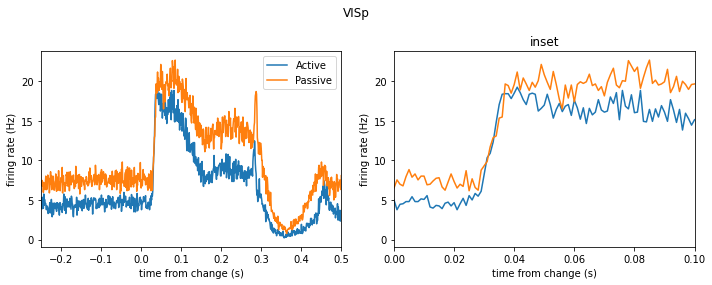

In [12]:
# here, we are doing the above two steps at the same time - looping over active and passive, and plotting 

fig, axes = plt.subplots(1,2)
fig.set_size_inches([10, 4])
fig.suptitle('VISp')

# Loop through our familiar and novel array indices
for change_indices in [active_array_indices, passive_array_indices]:
    
    # Use these indices to select the corresponding data from our data array
    relevant_trials = change_stim_array[:, :, change_indices]
    
    # We can use numpy mean to average over units and trials (the 0th and 2nd dimension of our array)
    mean_over_neurons_trials = np.mean(relevant_trials, axis=(0, 2))
    
    # Now plot. We're plotting twice to show two time scales.
    xlims = ([-0.25, 0.5], [0, 0.1])
    for ax, xlim in zip(axes, xlims):
        ax.plot(time, mean_over_neurons_trials)
        ax.set_xlim(xlim)
        ax.set_xlabel('time from change (s)')
        ax.set_ylabel('firing rate (Hz)')

axes[1].set_title('inset')
axes[0].legend(['Active', 'Passive'])

fig.tight_layout()

* You should see a difference between VISp responses to Active vs. Passive changes
* The largest difference is an overall shift in firing rate. What if we want to know whether the evoked firing rate relative to the baseline is the same or different in Active vs. Passive conditions?

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Bonus: baseline-subtracted PSTHs**

* If what we are interested in is the stimulus-evoked changes in firing rate, we need to correct for the baseline.
    
* Now, before averaging over neurons, first subtract each neuron's baseline firing rate (0.2 - 0 sec before the change).

</div>

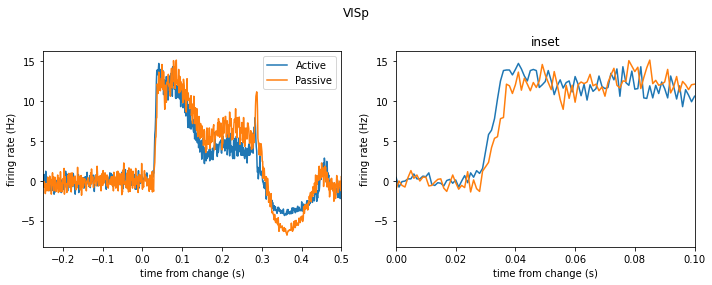

In [13]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches([10, 4])
fig.suptitle('VISp')

# Loop through our familiar and novel array indices
for change_indices in [active_array_indices, passive_array_indices]:
    
    # Use these indices to select the corresponding data from our data array
    relevant_trials = change_stim_array[:, :, change_indices]
    
    baseline_mean = np.mean(relevant_trials[:,(time>=-0.2)&(time<0), :], axis=(1,2))
    
    # Average over trials, then subtract the baseline before averaging over neurons
    mean_over_trials_minus_baseline = (np.mean(relevant_trials, axis=(2)).T-baseline_mean).T
    
    # Average over units 
    mean_over_neurons_trials = np.mean(mean_over_trials_minus_baseline, axis=(0))
    
    # Now plot. We're plotting twice to show two time scales.
    xlims = ([-0.25, 0.5], [0, 0.1])
    for ax, xlim in zip(axes, xlims):
        ax.plot(time, mean_over_neurons_trials)
        ax.set_xlim(xlim)
        ax.set_xlabel('time from change (s)')
        ax.set_ylabel('firing rate (Hz)')

axes[1].set_title('inset')
axes[0].legend(['Active', 'Passive'])

fig.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise 2.2: Plot running and pupil area averaged across Active vs. Passive image changes from the same session**

The lick spout is retracted, so mice are no longer performing behavior and there are no licks. Let's look at other measures of behavior, running and pupil size.
    
* 2.2.1: Get running speed and eye tracking tables
* 2.2.2: Align running and pupil data to Active vs. Passive changes
* 2.2.3: Average across trials
* 2.2.4: Plot these averages
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
**2.2.1: Get runnning speed and eye tracking tables**
    
</div>

In [14]:
# get the running speed table
running_speed = session.running_speed

# get the eye tracking table
eye_tracking = session.eye_tracking
eye_tracking_noblinks=eye_tracking.loc[eye_tracking['likely_blink']==False]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**2.2.2: Align running and pupil data to Active changes**
    
</div>

In [15]:
# running and pupil aligned to changes

#find active image change times
active_stimulus_times = stimulus_presentations['start_time'][
    (stimulus_presentations['is_change']==True)&
    (stimulus_presentations['active']==True)
]

#define how many frames worth of data to grab
pre_change_frames=200
post_change_frames=200
total_frames=400

#pre-allocate arrays to store stimulus-aligned data
active_stim_aligned_running = np.zeros((len(active_stimulus_times),total_frames))
active_stim_aligned_pupil = np.zeros((len(active_stimulus_times),total_frames))

#loop through image change times
for ii,rr in enumerate(active_stimulus_times.values):
    run_start_ind=np.where(running_speed['timestamps']>=rr)[0][0]
    
    #check that we aren't trying to grab data indices that don't exist
    if ((run_start_ind-pre_change_frames)>=0) & ((run_start_ind+post_change_frames)<len(running_speed)):
        #add this data to our array
        active_stim_aligned_running[ii,:]=running_speed['speed'][run_start_ind-pre_change_frames:
                                                                 run_start_ind+post_change_frames]
    else:
        active_stim_aligned_running[ii,:]=np.nan

    pupil_start_ind=np.where(eye_tracking_noblinks['timestamps']>=rr)[0][0]
    if ((pupil_start_ind-pre_change_frames)>=0) & ((pupil_start_ind+post_change_frames)<len(eye_tracking)):
        active_stim_aligned_pupil[ii,:]=eye_tracking_noblinks['pupil_area'][pupil_start_ind-pre_change_frames:
                                                                            pupil_start_ind+post_change_frames]
    else:
        active_stim_aligned_pupil[ii,:]=np.nan

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**2.2.3: Align running and pupil data to Passive changes**
    
</div>

In [16]:
#passive rewarded
passive_stimulus_times = stimulus_presentations['start_time'][
    (stimulus_presentations['is_change']==True)&
    (stimulus_presentations['active']==False)
]

passive_stim_aligned_running = np.zeros((len(passive_stimulus_times),total_frames))
passive_stim_aligned_pupil = np.zeros((len(passive_stimulus_times),total_frames))

for ii,rr in enumerate(passive_stimulus_times.values):
    run_start_ind=np.where(running_speed['timestamps']>=rr)[0][0]
    if ((run_start_ind-pre_change_frames)>=0) & ((run_start_ind+post_change_frames)<len(running_speed)):
        passive_stim_aligned_running[ii,:]=running_speed['speed'][run_start_ind-pre_change_frames:
                                                                  run_start_ind+post_change_frames]
    else:
        passive_stim_aligned_running[ii,:]=np.nan

    pupil_start_ind=np.where(eye_tracking_noblinks['timestamps']>=rr)[0][0]
    if ((pupil_start_ind-pre_change_frames)>=0) & ((pupil_start_ind+post_change_frames)<len(eye_tracking)):
        passive_stim_aligned_pupil[ii,:]=eye_tracking_noblinks['pupil_area'][pupil_start_ind-pre_change_frames:
                                                                             pupil_start_ind+post_change_frames]
    else:
        passive_stim_aligned_pupil[ii,:]=np.nan

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**2.2.4: Average across trials and plot**
    
</div>

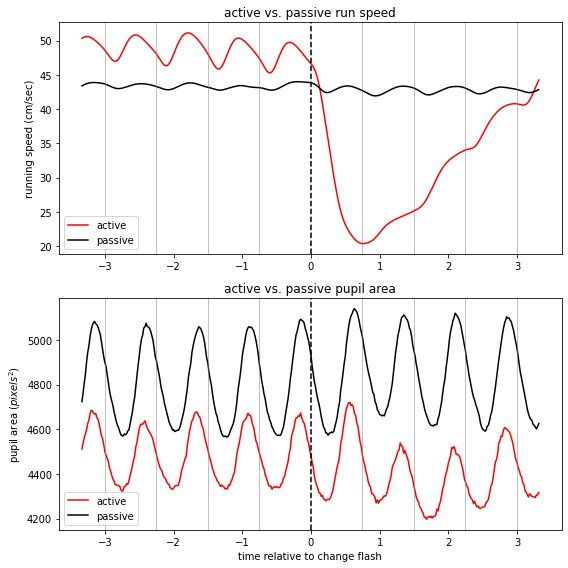

In [17]:
timevect=np.arange(-pre_change_frames/60,post_change_frames/60,1/60)

fig,ax=plt.subplots(2,1,figsize=(8,8))

ax[0].plot(timevect,np.nanmean(active_stim_aligned_running,0),'r')
ax[0].plot(timevect,np.nanmean(passive_stim_aligned_running,0),'k')
ax[0].axvline(0,color='k',linestyle='--')
stim_times=[-3,-2.25,-1.5,-0.75,0.75,1.5,2.25,3]
for ss in stim_times:
    ax[0].axvline(ss,color='grey',linewidth=0.5)
    
ax[0].set_ylabel('running speed (cm/sec)')
ax[0].set_title('active vs. passive run speed')
ax[0].legend(['active','passive'],loc='lower left')

ax[1].plot(timevect,np.nanmean(active_stim_aligned_pupil,0),'r')
ax[1].plot(timevect,np.nanmean(passive_stim_aligned_pupil,0),'k')
ax[1].axvline(0,color='k',linestyle='--')
for ss in stim_times:
    ax[1].axvline(ss,color='grey',linewidth=0.5)
    
ax[1].set_xlabel('time relative to change flash')
ax[1].set_ylabel('pupil area $(pixels^2)$')
ax[1].set_title('active vs. passive pupil area')
ax[1].legend(['active','passive'],loc='lower left')

fig.tight_layout()  